# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
# import necessary libraries and packages
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time as time
from time import sleep
pd.options.display.max_columns=30

In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-

## I. Business Understanding

### Project Goals
In this project, I will answer the following questions:
1. Which age groups, genders, and income groups are most likely to complete each offer?
2. Under which offer type (BOGO, DISCOUNT, INFORMATIONAL) do customers spend the most?
3. Does sending more offers increase the liklihood of an offer being completed?

Lastly, I will create a model that will predict the amount spent after receiving an offer
4. Create a machine learning model that will predict how much a user with certain demographics will spend after receiving a given offer_type.


## II. Data Understanding

In this step, I will explore the value counts and distributions of the variables in each of the tables

In [3]:
plt.style.use('fivethirtyeight')

In [121]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [86]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [87]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [88]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [89]:
# view shape of datasets
print('portfolio shape: ', portfolio.shape,
      '\nprofile shape: ', profile.shape, 
      '\ntranscript shape: ', transcript.shape)

portfolio shape:  (10, 6) 
profile shape:  (17000, 5) 
transcript shape:  (306534, 4)


### Portfolio DataFrame Understanding

In [90]:
print('portfolio_null_values:\n', portfolio.isnull().sum())

portfolio_null_values:
 reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


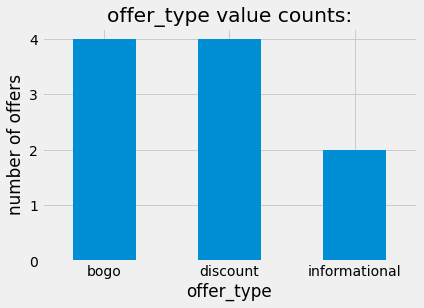

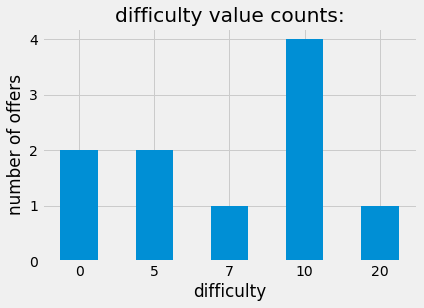

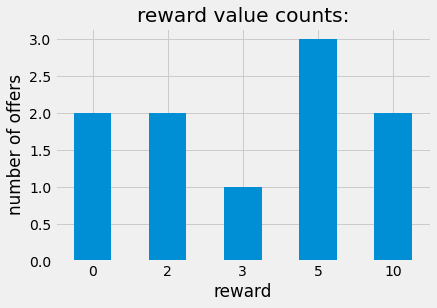

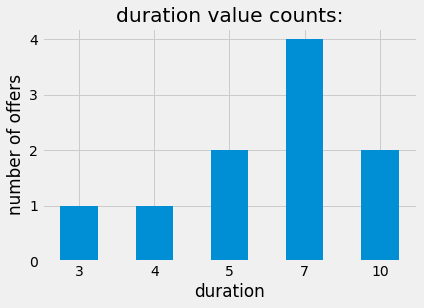

In [91]:
# How many of each offer type do we have? 

cols = ['offer_type', 'difficulty', 'reward', 'duration']

for col in cols:
    portfolio[col].value_counts().sort_index().plot.bar(title=col + " value counts:")
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.ylabel('number of offers')
    plt.show()


### Profile DataFrame Understanding

In [122]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [123]:
print('profile_null_values:\n', profile.isnull().sum())

profile_null_values:
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [125]:
age_118_idx = profile[profile['age'] == 118].index

gender_null_idx = profile[profile['gender'].isnull()].index

income_null_idx = profile[profile['income'].isnull()].index

set(age_118_idx) == set(gender_null_idx) == set(income_null_idx)

True

As I expected, the customers with null values in income nad gender also have an age of 118, which indicates that 118 was likely a placeholder to mean "unknown."

### Let's see how the demographic variables are distributed

<AxesSubplot:>

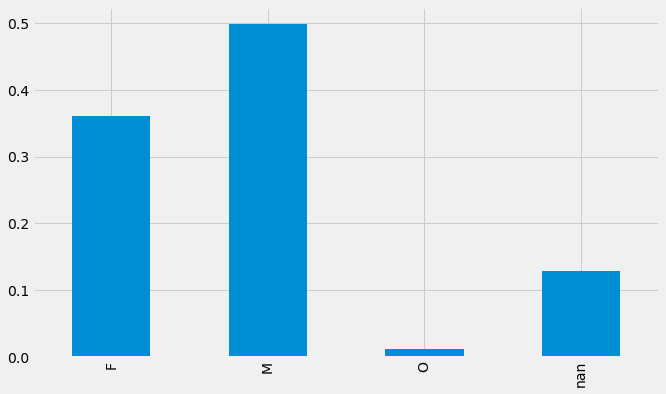

In [94]:
profile['gender'].value_counts(dropna=False, normalize=True).sort_index().plot.bar(figsize=(10,6))

In [95]:
def plot_hist(df, col, bin_size, x_range):
    """plots a histogram for a given column
    INPUTS
    df: df
    col (str): column in df
    bins (int): number of bins
    x_range (tup): range of x_values
    OUTPUTS
    histogram
    """
    rge = x_range[1] - x_range[0]
    bins = int(rge/bin_size)
    profile[col].plot.hist(figsize=(10,6), bins=bins, range=x_range, alpha=0.8)
    plt.xticks(ticks=np.arange(x_range[0], x_range[1]+1, bin_size))
    plt.xlabel(col)
    plt.title(col.title() + ' Histogram')
    plt.show()
    

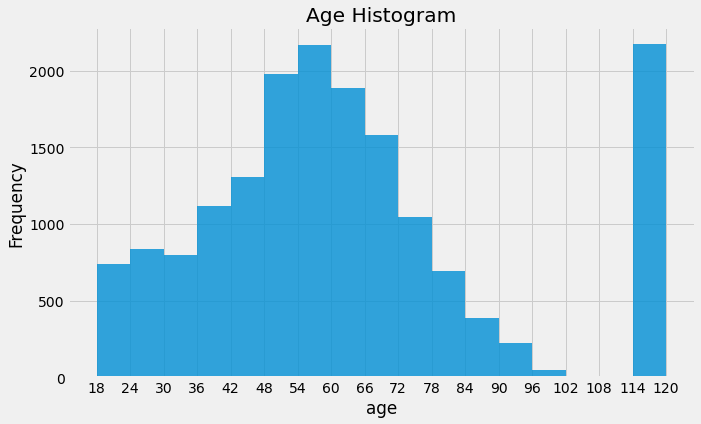

In [96]:
plot_hist(df=profile, col='age', bin_size=6, x_range=(18,120))

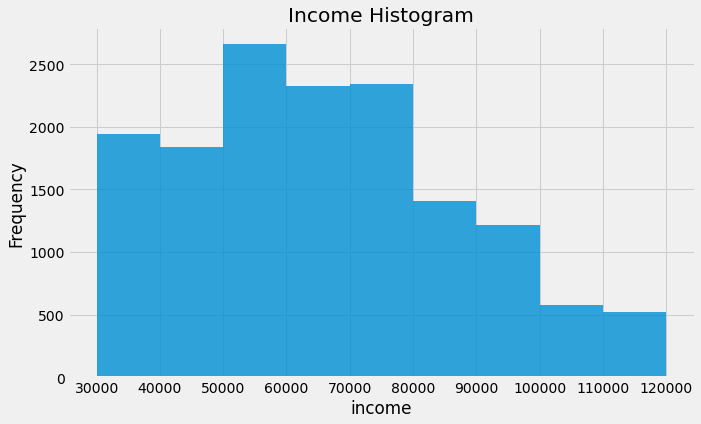

In [97]:
plot_hist(df=profile, col='income', bin_size=10000, x_range=(30000, 120000))

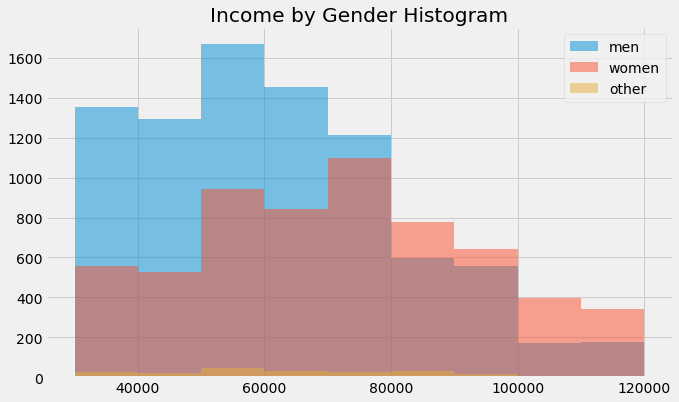

In [98]:
fig, ax = plt.subplots(figsize=(10,6))

bins = 9

men = profile.loc[profile['gender'] == 'M', 'income']
women = profile.loc[profile['gender'] == 'F', 'income']
other = profile.loc[profile['gender'] == 'O', 'income']

ax.hist(men, bins=9, range=(30000,120000), alpha=0.5, label='men')
ax.hist(women, bins=9, range=(30000,120000), alpha=0.5, label='women')
ax.hist(other, bins=9, range=(30000,120000), alpha=0.5, label='other')
ax.set_title('Income by Gender Histogram')
plt.legend()

In [99]:
profile.groupby('gender')['income'].median()

gender
F    71000.0
M    59000.0
O    62000.0
Name: income, dtype: float64

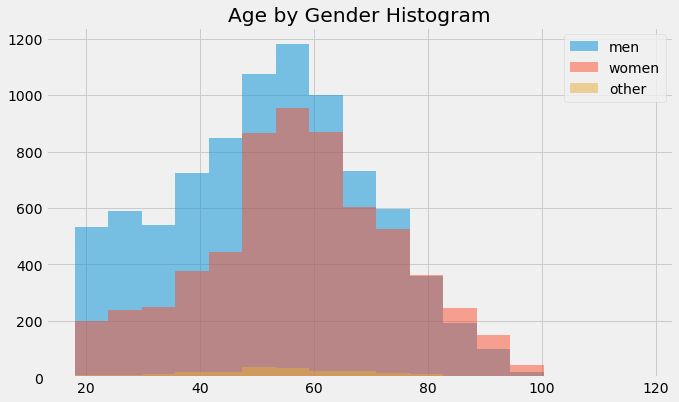

In [100]:
fig, ax = plt.subplots(figsize=(10,6))

bins=17

men = profile.loc[profile['gender'] == 'M', 'age']
women = profile.loc[profile['gender'] == 'F', 'age']
other = profile.loc[profile['gender'] == 'O', 'age']

ax.hist(men, bins=bins, range=(18,118), alpha=0.5, label='men')
ax.hist(women, bins=bins, range=(18,118), alpha=0.5, label='women')
ax.hist(other, bins=bins, range=(18,118), alpha=0.5, label='other')
ax.set_title('Age by Gender Histogram')
plt.legend()

In [101]:
profile.groupby('gender')['age'].median()

gender
F    58
M    53
O    55
Name: age, dtype: int64

381.0613743091652 44677.72038712164


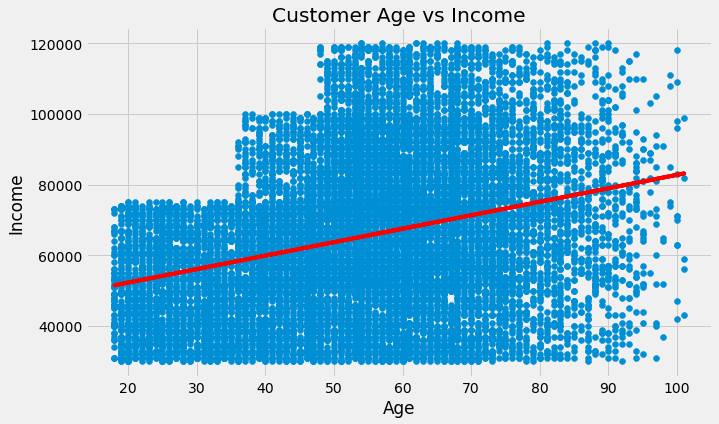

In [102]:
fig, ax = plt.subplots(figsize=(10,6))

data=profile.dropna()

X = data['age']
Y = data['income']
m, b = np.polyfit(X, Y, 1)
print(m, b)

ax.scatter(x=X, y=Y)
ax.plot(X, m*X+b, c='red')
ax.set_title('Customer Age vs Income')
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_xticks(np.arange(20, 101, 10))

In [103]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [104]:
transcript.shape

(306534, 4)

Text(0.5, 1.0, 'Event Types')

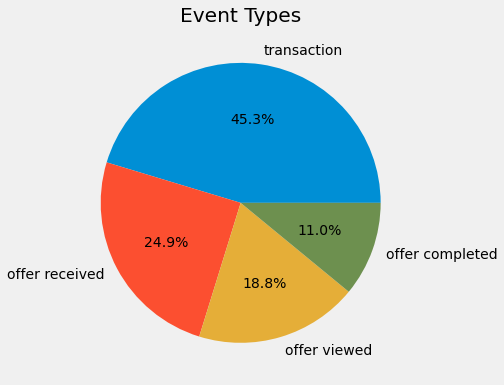

In [105]:
transcript['event'].value_counts(normalize=True).plot.pie(figsize=(10,6), autopct='%1.1f%%')
plt.ylabel('')
plt.title('Event Types')

In [106]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [107]:
transcript['person'].nunique()

17000

### Data Understanding Summary

#### Portfolio

1. There are 10 different offers - 2 informational, 4 bogo, 4
2. The offer difficulties range from \\$0 \(for informational offers\) to \\$20, the most common being \\$10.
3. The offer rewards range from \\$0 \(for informational offers to\) \\$10, the most common being \\$5.
4. The offer durations range from 3 days to 10 days, the most common being 7 days.

#### Profile
1. There are 170,000 customers
2. There are 2,175 customers with null values in income and gender.
3. Ages range from 18 to 118. However, it appears 118 is used as a place holder, most likely indicating "unknown/not given" as customers with that age also have null values for income and gender.
4. The variable became_member_on is formated as an int, but should be converted to a datetime object for us to make use of it.
5. Income ranges from 30k to 120k, with the median being 64k.
6. The median income for female customers is \\$71k, \\$59k for male customers, and \\$62k for customers who marked Other.
7. The median age for female customers is 58, for male customers 53, and 55 for customers who marked their gender as Other.
8. Age and Income are positively correlated.
9. There are no customers between 18 and 36 who make over \\$75k. There are no users under 48 who make more than 100k.

#### Transcript
1. There are 306,534 rows, with each row being one of four events: 'offer received', 'offer viewed', 'offer completed', or 'transaction'.
2. 45.3% of the rows are transactions, 24.9% are offer received, 18.8% are offer viewed events, and 11% are offer completed.
3. The value column is a dictionary that gives the offer_id for an "offer received", "offer viewed" or "offer completed" event, and a transaction amount if the event is a transaction. <br>We will want to clean this columnn in the next section.
4. The times range from 0 to 714, and indicate the hour that the event occured in. The experiment ran for about 30 days. 


## III. Data Preparation

In this section I will clean each of the tables so that I can answer my questions and prepare the data for my model.
<br><br>**Portfolio DataFrame**

1. Add a column "readable_id" which contains a unique id that is easier to read than the hash id.
2. One-hot encode the channels column: 'email', 'mobile', 'social' or 'web'.
3. One-hot encode the offer_type: "bogo", "discount", or "informational".

<br>**Profile DataFrame**

1. Convert "became_member_on" column to a datetime object.
2. Extract the year a member joined and store in the column "year_joined."
3. Replace the customers with age 118 with NaNs and drop the rows with null values. I decieded to drop these rows because these customers were missing data from all three demographic variables,<br>
and thus they wouldn't be helpful in answering my questions.
4. Create the column "age_group" with the following age groups: 18-24, 25-34, 35-44, 45-54, 55-65, 65-74, 75+.
5. Create the column "income_group" with the following income groups: 30-45k, 45-60k, 60-75k, 75-90k, 90-105k, 105-120k (ranges include the left endpoint and exclude the right endpoint).

<br>**Transcript**
1. Extract the offer id, amount, or reward from the dictioanry in the value column and store in its own column.
2. Drop the original value column

<br>**Create Mater DataFrame**
1. Merge the profile and transaction datasets.
2. Merge the resulting dataset with the profile dataset.
3. Drop repeated columns and reorder for readability. 

In [330]:
def clean_portfolio(df=portfolio):
    # Create an ID column that is more readable than the id hash
    df['readable_id'] = ['BOGO - $10 - 7days', 'BOGO - $10 - 5days', 'INFO - $0 - 4days', 'BOGO - $5 - 7days',
                           'DISC - $20/\$5 - 10days', 'DISC - $7/\$3 - 7days', 'DISC - $10/\$2 - 10days', 'INFO - $0 - 3days',
                           'BOGO - $5 - 5days', 'DISC - \$10/\$2 - 7days']
    
    # Extract channels into their own columns one-hot encoded
    df['email'] = df['channels'].apply(lambda x: 1 if 'email' in x else 0)
    df['mobile'] = df['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    df['social'] = df['channels'].apply(lambda x: 1 if 'social' in x else 0)
    df['web'] = df['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
  
    # Drop unneeded columns
    df.drop(columns=['channels'], inplace=True, errors='ignore')
   
    
    # Turn offer_type into a dummy variable
    df = pd.get_dummies(df, columns=['offer_type'], prefix='', prefix_sep='')
    
    # Rename dummy columns
    df = df[['readable_id', 'id', 'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']]
    

    return df

clean_portfolio = clean_portfolio(df=portfolio)
clean_portfolio.to_csv('clean_portfolio.csv', index=False)


In [331]:
clean_portfolio.head(10)

,readable_id,id,difficulty,reward,duration,email,mobile,social,web,bogo,discount,informational
0,BOGO - $10 - 7days,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,BOGO - $10 - 5days,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,INFO - $0 - 4days,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,BOGO - $5 - 7days,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,DISC - $20/\$5 - 10days,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,1,0,0,1,0,1,0
5,DISC - $7/\$3 - 7days,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,7,1,1,1,1,0,1,0
6,DISC - $10/\$2 - 10days,fafdcd668e3743c1bb461111dcafc2a4,10,2,10,1,1,1,1,0,1,0
7,INFO - $0 - 3days,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,1,1,0,0,0,1
8,BOGO - $5 - 5days,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,DISC - \$10/\$2 - 7days,2906b810c7d4411798c6938adc9daaa5,10,2,7,1,1,0,1,0,1,0


In [127]:
def clean_profile(df=profile):
    
    # Convert column to datetime object
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    
    # Extract the year 
    df['year_joined'] = pd.DatetimeIndex(df['became_member_on']).year
    
    # Change 118 to nan. This was likely used as a placeholder to indicate unknown.
    # Customers with this age also had null values for income and gender
    df.loc[df['age'] == 118] = np.nan
    
    orig_num_rows = df.shape[0]
    print('Original Number of Rows: ', orig_num_rows)
        
    # Drop nulls - We do not have any demographic information regarding these customers to work with
    df = df.dropna(axis=0)
            
    final_num_rows = df.shape[0]
    print('Final Number of Rows: ', final_num_rows)
    print('Null Values Dropped: ', orig_num_rows - final_num_rows)
    
    
    # create age groups 
    cond_lst = [df['age'].between(18,24),
            df['age'].between(25,34),
            df['age'].between(35,44),
            df['age'].between(45,54),
            df['age'].between(55,64),
            df['age'].between(65,74),
            df['age'].between(75,117),
            df['age'] == 118]
    choice_lst = ["18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75+"]
    df['age_group'] = np.select(condlist = cond_lst, choicelist=choice_lst)
    

    cond_lst = [df['income'].between(30000,44999),
                df['income'].between(45000,59999),
                df['income'].between(60000,74999),
                df['income'].between(75000,89999),
                df['income'].between(90000,104999),
                df['income'].between(105000,120000),
                df['income'].isnull()]
    choice_lst = ["30-45k", "45-60k", "60-75k", "75-90k", "90-105k", "105k+"]

    df['income_group'] = np.select(condlist = cond_lst, choicelist=choice_lst)    
    
    
    return df

clean_profile = clean_profile(df=profile)
clean_profile.to_csv('clean_profile.csv',index=False)

Original Number of Rows:  17000
Final Number of Rows:  14825
Null Values Dropped:  2175


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [135]:
clean_profile.head()

,gender,age,id,became_member_on,income,year_joined,age_group,income_group
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017.0,55-64,105k+
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017.0,75+,90-105k
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018.0,65-74,60-75k
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018.0,65-74,45-60k
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017.0,55-64,45-60k


In [130]:
def clean_transcript(df=transcript):
    df['transaction_amt'] = df.apply(lambda row: row['value']['amount'] if 'amount' in row['value'].keys() else np.nan, axis=1)
    df['offer_id'] = df.apply(lambda row: row['value']['offer id'] if 'offer id' in row['value'].keys() else np.nan, axis=1)
    df['reward'] = df.apply(lambda row: row['value']['reward'] if 'reward' in row['value'].keys() else np.nan, axis=1)
    
    df.drop(columns=['value'], inplace=True, errors='ignore')
    
    return df

clean_transcript = clean_transcript(df=transcript)
clean_transcript

,person,event,time,transaction_amt,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN


In [173]:
clean_transcript.to_csv('clean_transcript.csv', index=False)

In [209]:
def create_merged_df(portfolio_df=clean_portfolio, profile_df=clean_profile, transcript_df=clean_transcript):
    """Merges the three datasets to one master df
    INPUTS
    portfolio_df: dataframe of offers including and 'offer_id' column with offer id's
    profile_df: dataframe of customer demographic data including an 'id' column with customer id's
    transcript_df: dataframe of every event during experiment including offer_id column and customer_id column
    
    OUTPUTS
    master_df: a dataframe of every event during experiment with demographic data
    """
    
    # merge transcript_df and profile_df on customer id
    df = pd.merge(profile_df, transcript_df, how='left', left_on='id', right_on='person')
    
    # drop 'id' column because this is the same as the 'person' column
    df.drop(columns=['id'], inplace=True)
    
    # merge above df with portfolio_df to include information about offers
    merged_df = pd.merge(df, portfolio_df, how='left', left_on='offer_id', right_on='id')
    
    # drop reward_x column, as we only need the reward in the offer_received events and drop 'id' and 'offer_id' as we have the readable_id' now.
    merged_df.drop(columns=['reward_x', 'id', 'offer_id'], inplace=True)
    
    merged_df = merged_df[['person', 'gender', 'age', 'became_member_on', 'income', 'year_joined', 'age_group', 'income_group', 'event', 'time', 'transaction_amt',
                          'readable_id', 'difficulty', 'reward_y', 'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']]
    
    merged_df.rename(columns={'reward_y':'reward'})
    
    return merged_df
    
create_merged_df()

,person,gender,age,became_member_on,income,year_joined,age_group,income_group,event,time,transaction_amt,readable_id,difficulty,reward_y,duration,email,mobile,social,web,bogo,discount,informational
0,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,transaction,18,21.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,transaction,144,32.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,offer received,408,NaN,BOGO - $5 - 7days,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,offer received,504,NaN,INFO - $0 - 4days,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,transaction,528,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer completed,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272758,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,transaction,486,19.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272759,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer viewed,546,NaN,BOGO - $5 - 5days,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
272760,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer received,576,NaN,INFO - $0 - 4days,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [210]:
merged_df = create_master_df()

In [225]:
person = merged_df.loc[merged_df['person'] == '0610b486422d4921ae7d2bf64640c50b']

In [238]:
for row in person.itertuples():
    print('time:', row.time)
    print(row.Index)

time: 18
0
time: 144
1
time: 408
2
time: 504
3
time: 528
4
time: 528
5


In [258]:
# will take a while to run
def group_transactions_by_offer(df = merged_df):
    """
    This function loops through the customers and does 4 things for each
    'offer received' event: 
    
    Let the "offer window" be defined as the time an offer was received
    to the "offer_valid_until" time. 
    
    1. Sums up all their transactions that were between the offer window
       and stores value in 'amt_spent_under_offer' column.
    2. Determines if a received offer was viewed and stores a 1 in the 
       column "offer_viewed" if so. A received offer was viewed if 
       there is an "offer viewed" event in the offer window AND it has
       the same readable_id.  
    3. Determines if a received offer was completed and stores a 1 in 
       the column "offer_completed" if so. A received offer was 
       completed if there was an "offer completed" event in the offer
       window AND the received offer was not informational.
    4. Creates a column "offer_successful" and places a 1 if the offer
       was both viewed AND completed.
       
    Lastly, it subsets only the offer received events, as they now contain
    all the information we need. 
    
    """
    df['amt_spent_under_offer'] = 0
    df['offer_completed'] = 0
    df['offer_viewed'] = 0
    df['offer_valid_until'] = np.nan
    df.loc[df['event'] == 'offer received', 'offer_valid_until'] = (df.loc[df['event'] == 'offer received', 'time'] 
                                                                                  + df.loc[df['event'] == 'offer received', 'duration'] * 24)
    

    for person in tqdm(df['person'].unique(), desc='Progress'):
        # Create a dataframe of only 1 person's events
        customer_data = df.loc[df['person'] == person]
        
        # Create a dataframe of only offer received events
        customer_offers = customer_data.loc[customer_data['event'] == 'offer received']
        
        customer_viewed_offers = customer_data.loc[customer_data['event'] == 'offer viewed']
        
        customer_completed_offers = customer_data.loc[customer_data['event'] == 'offer completed']
              
        for offer in customer_offers.itertuples():
            
            idx = offer.Index
            offer_start = offer.time 
            offer_end = offer.offer_valid_until
            offer_id = offer.readable_id
            
            amt_spent = customer_data.loc[(customer_data['time'].between(offer_start, offer_end))
                                          & (customer_data['event'] == 'transaction'), 'transaction_amt'].sum()
            
            df.at[idx, 'amt_spent_under_offer'] = amt_spent
            
            for view in customer_viewed_offers.itertuples(index=False):
                if offer_start <= view.time and view.time <= offer_end and view.readable_id == offer_id:
                    df.at[idx, 'offer_viewed'] = 1
                    break          $SS
                    
            for completed in customer_completed_offers.itertuples(index=False):
                if offer_start <= completed.time and completed.time <= offer_end and offer.informational ==  0:
                    df.at[idx, 'offer_completed'] = 1
                    break

                    
    master_df = df.loc[df['event'] == 'offer received']
       
    master_df.loc['offer_successful'] = ((master_df['offer_completed'] + master_df['offer_viewed']) == 2).astype(int)
                    
    return master_df



In [261]:
master_df = group_transactions_by_offer()

Progress: 100%|██████████████████████████████████████████████████████████████████| 14825/14825 [15:55<00:00, 15.51it/s]
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [274]:
master_df.to_csv('master_df.csv', index=False)

In [192]:
master_df['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [198]:
num_offers_received = master_df.loc[master_df['event'] == 'offer received'].shape[0]
num_offers_viewed = master_df['offer_viewed'].sum()

# completed offers may have been viewed or not
num_offers_completed = master_df['offer_completed'].sum()

# A successful offer is one that was viewed and completed
num_offers_successful = master_df['offer_successful'].sum()

print('num_offers_received: ', num_offers_received)
print('num_offers_viewed: ', num_offers_viewed)
print('num_offers_completed: ', num_offers_completed)
print('num_offers_successful: ', num_offers_successful)

num_offers_received:  66501
num_offers_viewed:  49126
num_offers_completed:  33462
num_offers_successful:  27456


In [401]:
master_df['offer_successful'] = (master_df['offer_completed'] + master_df['offer_viewed'] == 2).astype(int)
master_df

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,person,gender,age,became_member_on,income,year_joined,age_group,income_group,event,time,transaction_amt,readable_id,difficulty,reward_y,duration,email,mobile,social,web,bogo,discount,informational,amt_spent_under_offer,offer_completed,offer_viewed,offer_valid_until,offer_successful
2,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,offer received,408.0,NaN,BOGO - $5 - 7days,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,23.0,1.0,0.0,576.0,0
3,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,offer received,504.0,NaN,INFO - $0 - 4days,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,23.0,0.0,0.0,600.0,0
6,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,2017.0,75+,90-105k,offer received,0.0,NaN,BOGO - $5 - 7days,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,37.0,1.0,1.0,168.0,1
11,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,2017.0,75+,90-105k,offer received,168.0,NaN,INFO - $0 - 3days,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,49.0,0.0,1.0,240.0,0
16,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,2017.0,75+,90-105k,offer received,408.0,NaN,BOGO - $10 - 7days,10.0,10.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,48.0,1.0,1.0,576.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272748,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer received,0.0,NaN,DISC - $7/$3 - 7days,7.0,3.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,68.0,1.0,1.0,168.0,1
272754,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer received,336.0,NaN,INFO - $0 - 4days,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,432.0,0
272755,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer received,408.0,NaN,BOGO - $5 - 5days,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,50.0,1.0,0.0,528.0,0
272760,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer received,576.0,NaN,INFO - $0 - 4days,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,672.0,0


## IV. Evaluate the Results

#### 1. Which age groups, genders, and income groups are most likely to successfully complete each offer?


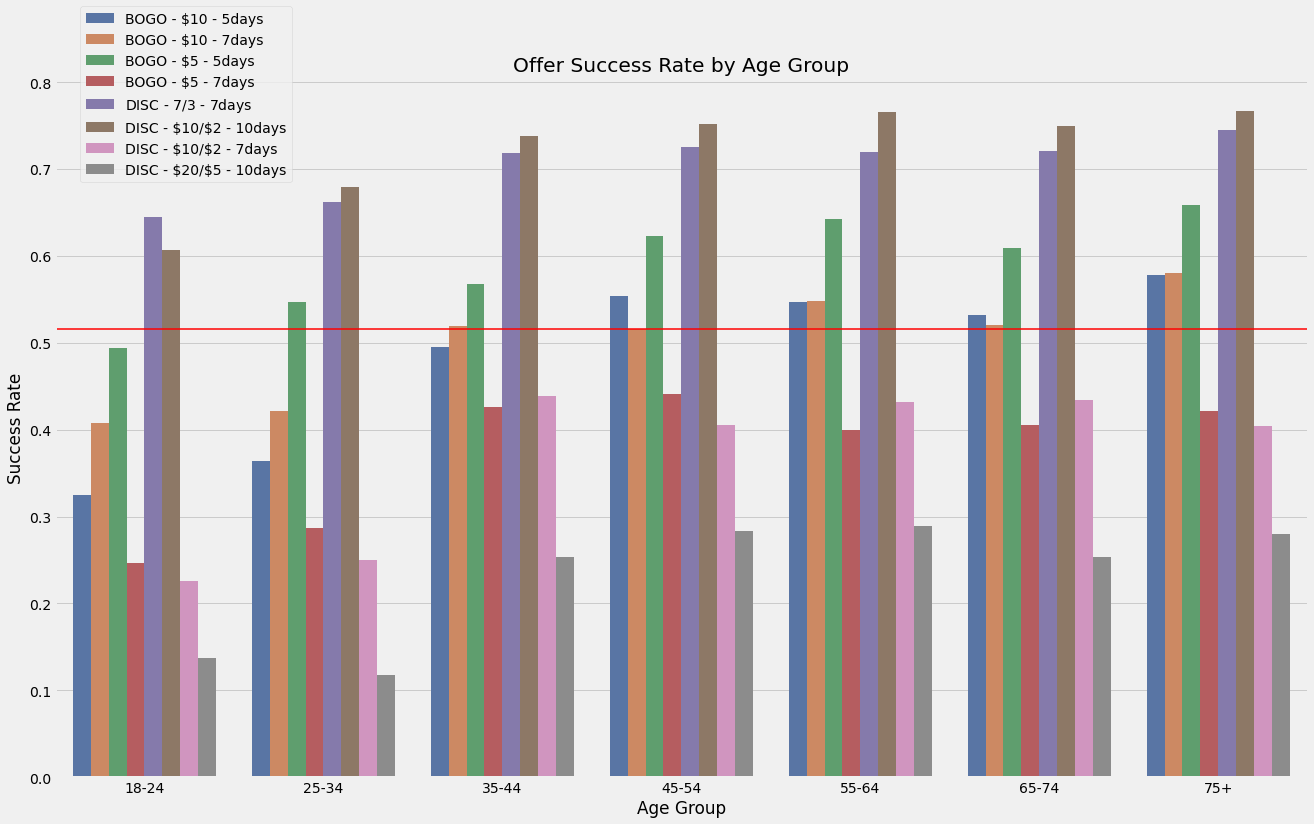

In [497]:
success_rate_by_age = bogo_disc_offers.groupby(['age_group', 'readable_id'])['offer_successful'].mean().reset_index()

avg_success_rate = bogo_disc_offers['offer_successful'].mean()


fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(data = success_rate_by_age, x='age_group', y='offer_successful', hue='readable_id', ax=ax, palette='deep')
ax.set_ylabel('Success Rate')
ax.set_xlabel('Age Group')
ax.set_title('Offer Success Rate by Age Group')

ax.axhline(avg_success_rate, color='red', linewidth=1.5)

plt.legend(loc=(0.02,0.85))


Across all age groups, the two offers with the highest success rate are the discount offers \\$10/\\$2 that is valid 10 days and the \\$7/\\$3 that lasts 7 days. 
The two offers with the lowest success rate are the remaining two discount offers (\\$20/\\$5 - 10days and \\$10/\\$2 - 7days).


Among BOGO offers, the highest completed is the \\$5 5day offer. The lowest success rate is for offer \\$5 7day offer.


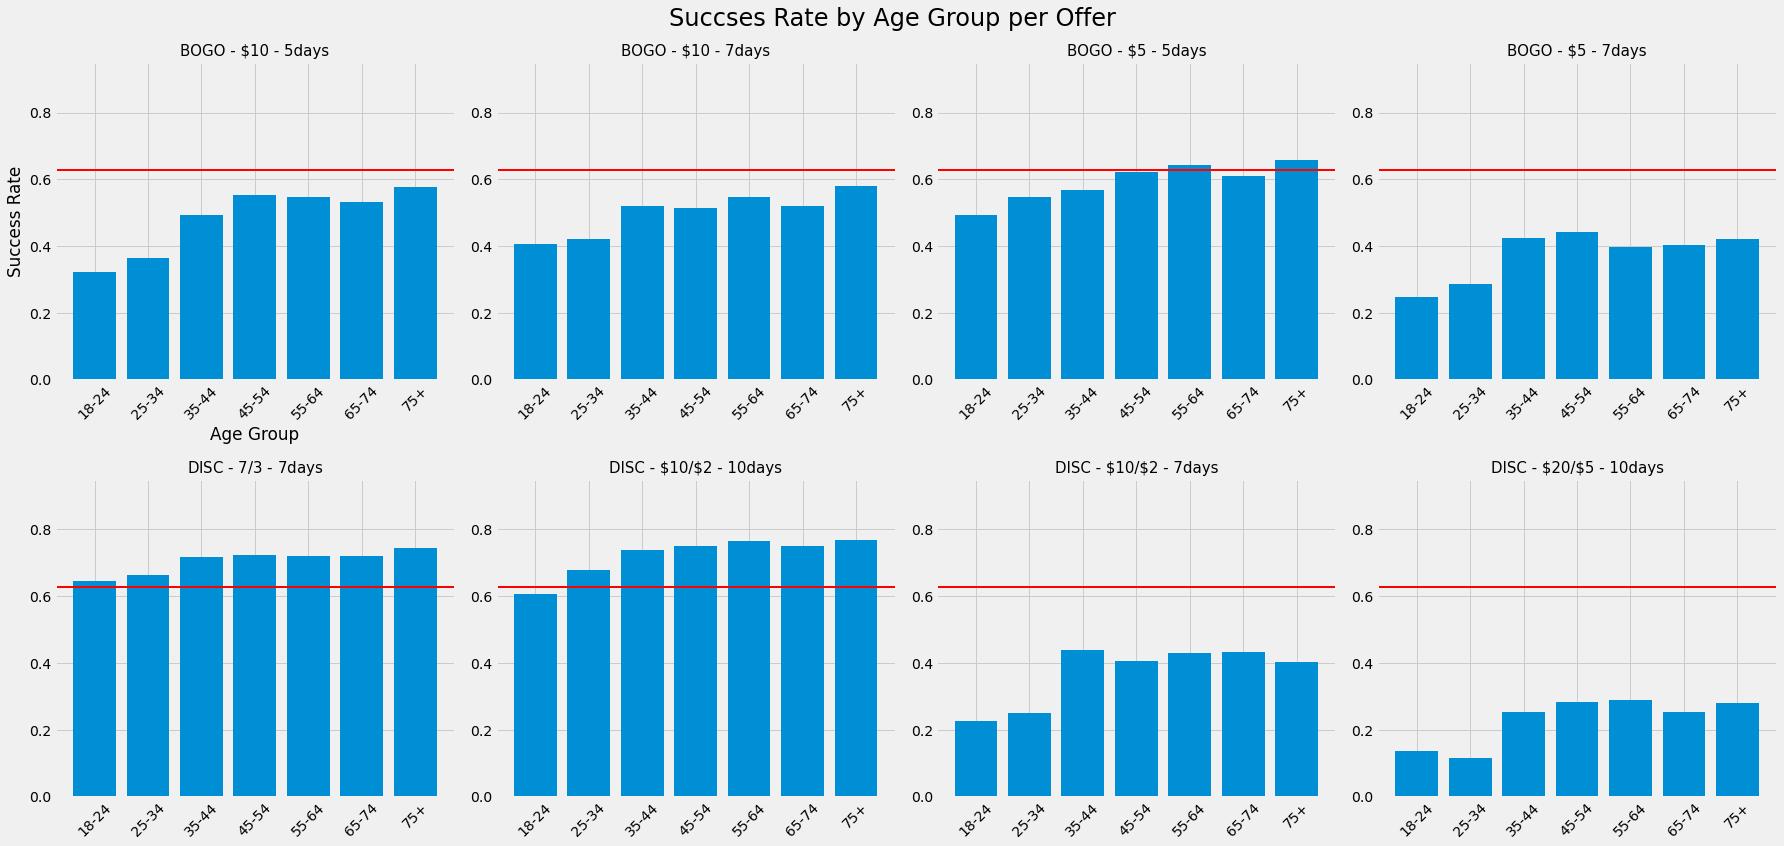

In [457]:
# Filter offers to only include BOGO and DISCOUNTs (informational offers have no difficulty and thus cannot be completed)
bogo_disc_offers = master_df.loc[master_df['informational'] == 0]

# Group by offer and age_group, and calculate the average success rate for each
success_rate_by_age = bogo_disc_offers.groupby(['readable_id', 'age_group'])['offer_successful'].mean().reset_index()

# Find the average success rate
avg_success_rate = bogo_disc_offers['offer_completed'].mean()

# Create a figure object
fig = plt.figure(figsize=(25,12))

# Loop through the unique offers
for i, offer in enumerate(np.sort(bogo_disc_offers['readable_id'].unique())):
    
    # Add an axes on the subplot in the figure
    ax = fig.add_subplot(2, 4, i+1, sharey=ax)
    
    # Select only current offer
    data = success_rate_by_age.loc[success_rate_by_age['readable_id'] == offer]
    
    # Set x and y values
    x = data['age_group']
    y = data['offer_successful']
    
    # Create bar chart
    ax.bar(x, y)
    
    # Create x and y labels for only the first subplot
    if i == 0:
        ax.set_xlabel('Age Group')
        ax.set_ylabel('Success Rate')
    
    ax.set_title(data['readable_id'].iloc[0], fontsize=15)
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(avg_completion_rate, color='red', linewidth=2)

fig.suptitle('Succses Rate by Age Group per Offer', fontsize=24)
fig.tight_layout()





In [453]:
table = pd.pivot_table(master_df, index=['readable_id'], columns=['age_group'], values=['offer_successful'], aggfunc=np.mean)
table.columns = table.columns.droplevel()
table

age_group,18-24,25-34,35-44,45-54,55-64,65-74,75+
readable_id,,,,,,,
BOGO - $10 - 5days,0.324519,0.363492,0.495037,0.554135,0.547020,0.531703,0.578419
BOGO - $10 - 7days,0.408108,0.421875,0.519819,0.515891,0.548243,0.520510,0.580645
BOGO - $5 - 5days,0.493857,0.547297,0.567367,0.623037,0.642484,0.609621,0.658537
BOGO - $5 - 7days,0.246753,0.287113,0.425606,0.441389,0.399220,0.405258,0.421581
DISC - $7/$3 - 7days,0.644928,0.662316,0.718714,0.724843,0.720077,0.720930,0.745387
DISC - \$10/\$2 - 10days,0.606557,0.679104,0.738007,0.751908,0.765783,0.750000,0.766965
DISC - \$10/\$2 - 7days,0.226328,0.249600,0.438813,0.405667,0.431715,0.434584,0.403822
DISC - \$20/\$5 - 10days,0.137203,0.117175,0.253837,0.283005,0.288917,0.253235,0.279951
INFO - $0 - 3days,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


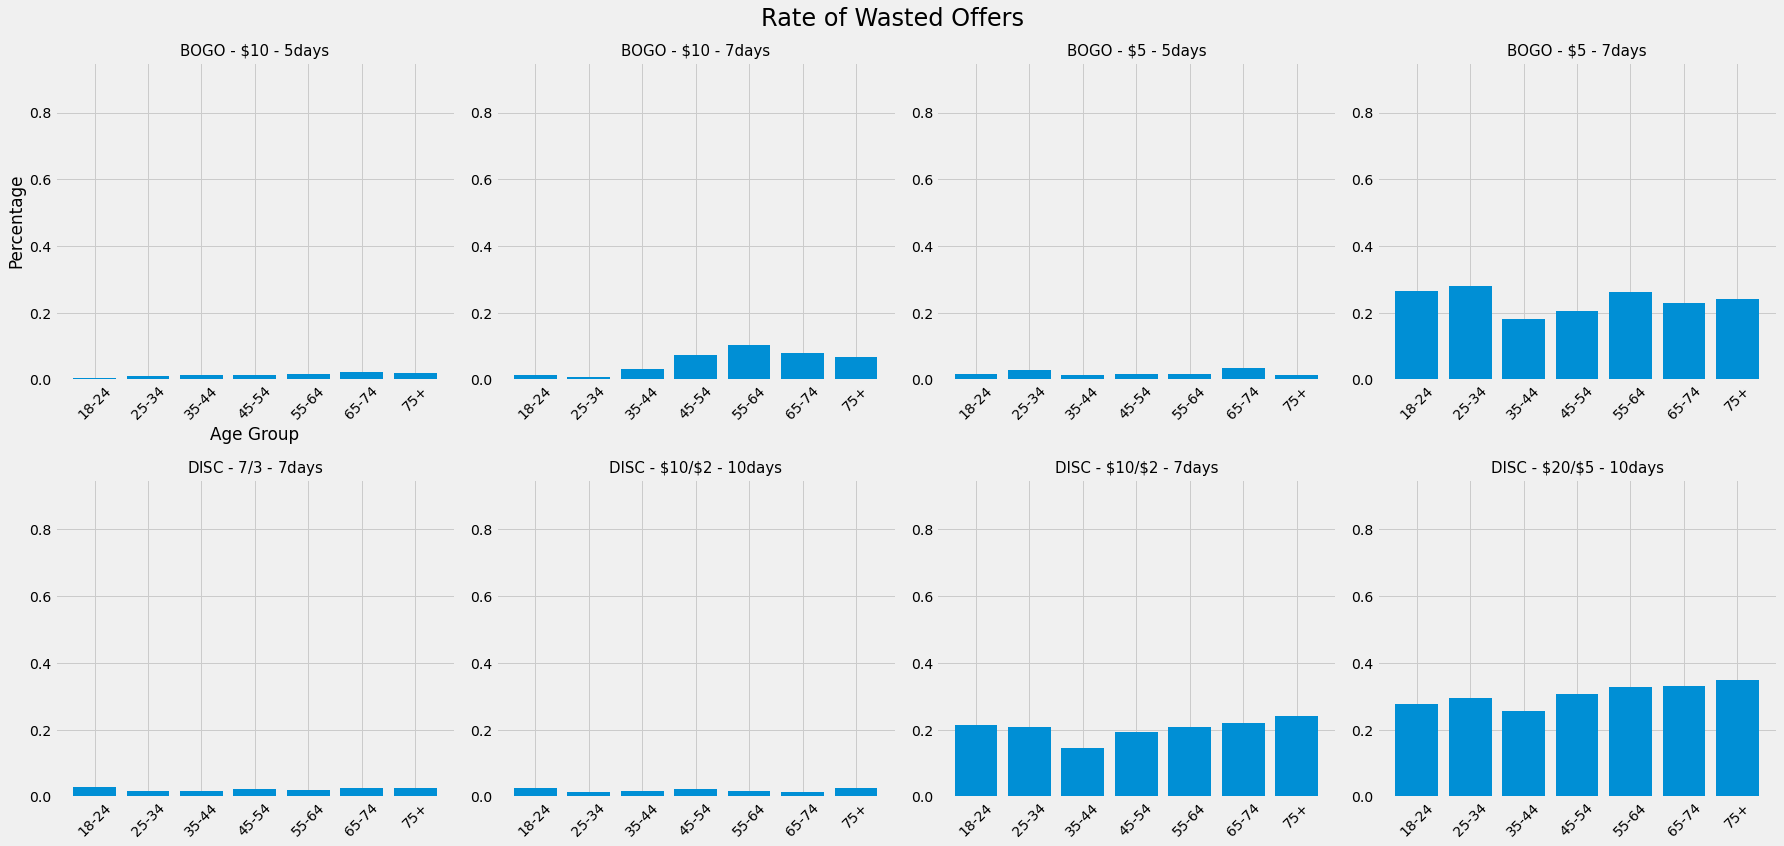

In [418]:
bogo_disc_offers = master_df.loc[master_df['informational'] == 0]
completed_not_viewed = bogo_disc_offers.loc[(bogo_disc_offers['offer_completed'] == 1) & (bogo_disc_offers['offer_viewed'] == 0)]
completed_not_viewed
wasted_offer_rate_by_age = completed_not_viewed.groupby(['readable_id', 'age_group'])['offer_completed'].sum().reset_index()
wasted_offer_rate_by_age['percent'] = wasted_offer_rate_by_age['offer_completed'] / bogo_disc_offers.groupby(['readable_id', 'age_group'])['offer_completed'].size().reset_index()['offer_completed']

wasted_offer_rate_by_age

fig = plt.figure(figsize=(25,12))

for i, offer in enumerate(np.sort(bogo_disc_offers['readable_id'].unique())):
    ax = fig.add_subplot(2, 4, i+1, sharey=ax)
    data = wasted_offer_rate_by_age.loc[wasted_offer_rate_by_age['readable_id'] == offer]
    x = data['age_group']
    y = data['percent']
    ax.bar(x, y)
    
    if i == 0:
        ax.set_xlabel('Age Group')
        ax.set_ylabel('Percentage')
    
    ax.set_title(data['readable_id'].iloc[0], fontsize=15)
    ax.tick_params(axis='x', rotation=45)

fig.suptitle('Rate of Wasted Offers', fontsize=24)
fig.tight_layout()

Takeaways:

1. It appears across all 8 offers, the 75+ demographic has the highest completion rates. 
2. The one exception is for the \\$5 and \\$10 BOGO offers that last 7 days, the 55-64 demographic are about equal to the 75+. 
3. The younger demographics (18-24 and 25-45) complete all the offers at lowest rates.
4. Overall, the older the customers are, the more likely they are to complete offers. 

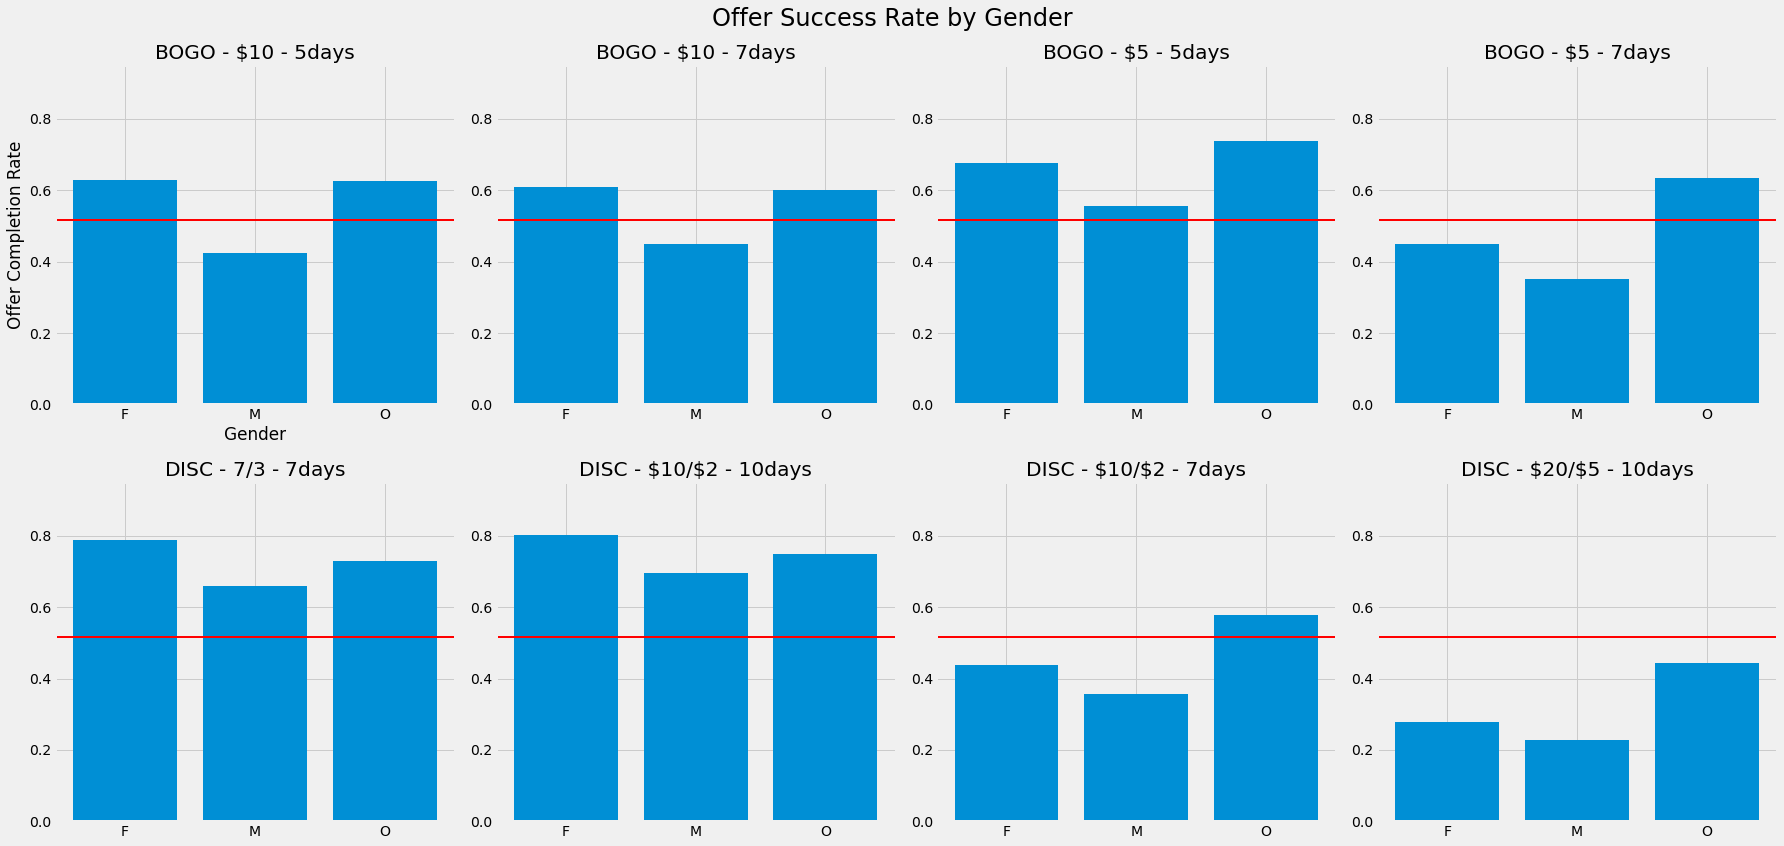

In [461]:
success_rate_by_gender = bogo_disc_offers.groupby(['readable_id', 'gender'])['offer_successful'].mean().reset_index()
avg_success_rate = bogo_disc_offers['offer_successful'].mean()

fig = plt.figure(figsize=(25,12))

for i, offer in enumerate(np.sort(bogo_disc_offers['readable_id'].unique())):
    ax = fig.add_subplot(2, 4, i+1, sharey=ax)
    data = success_rate_by_gender.loc[success_rate_by_gender['readable_id'] == offer]
    x = data['gender']
    y = data['offer_successful']
    ax.bar(x, y)
    
    if i == 0:
        ax.set_xlabel('Gender')
        ax.set_ylabel('Offer Completion Rate')
    
    ax.set_title(data['readable_id'].iloc[0])
    ax.axhline(avg_success_rate, color='red', linewidth=2)

fig.suptitle('Offer Success Rate by Gender', fontsize=24)
fig.tight_layout()

Across all offers, female customers have higher completion rates than male customers. In the BOGO\\$5 5 day and 7 day offer and the DISCOUNT \\$10/\\$2 and \\$20/\\$5 customers with gender O have highest rates of successful offers. It's important to note that gender O customers make up about 1\% of the customers in the experiment. so the sample size for those subsets are low. The \\$7/\\$3 off and \\$10/\\$2 off had particularly high rates of completion around 80% for female customers and just under 70% for male customers.


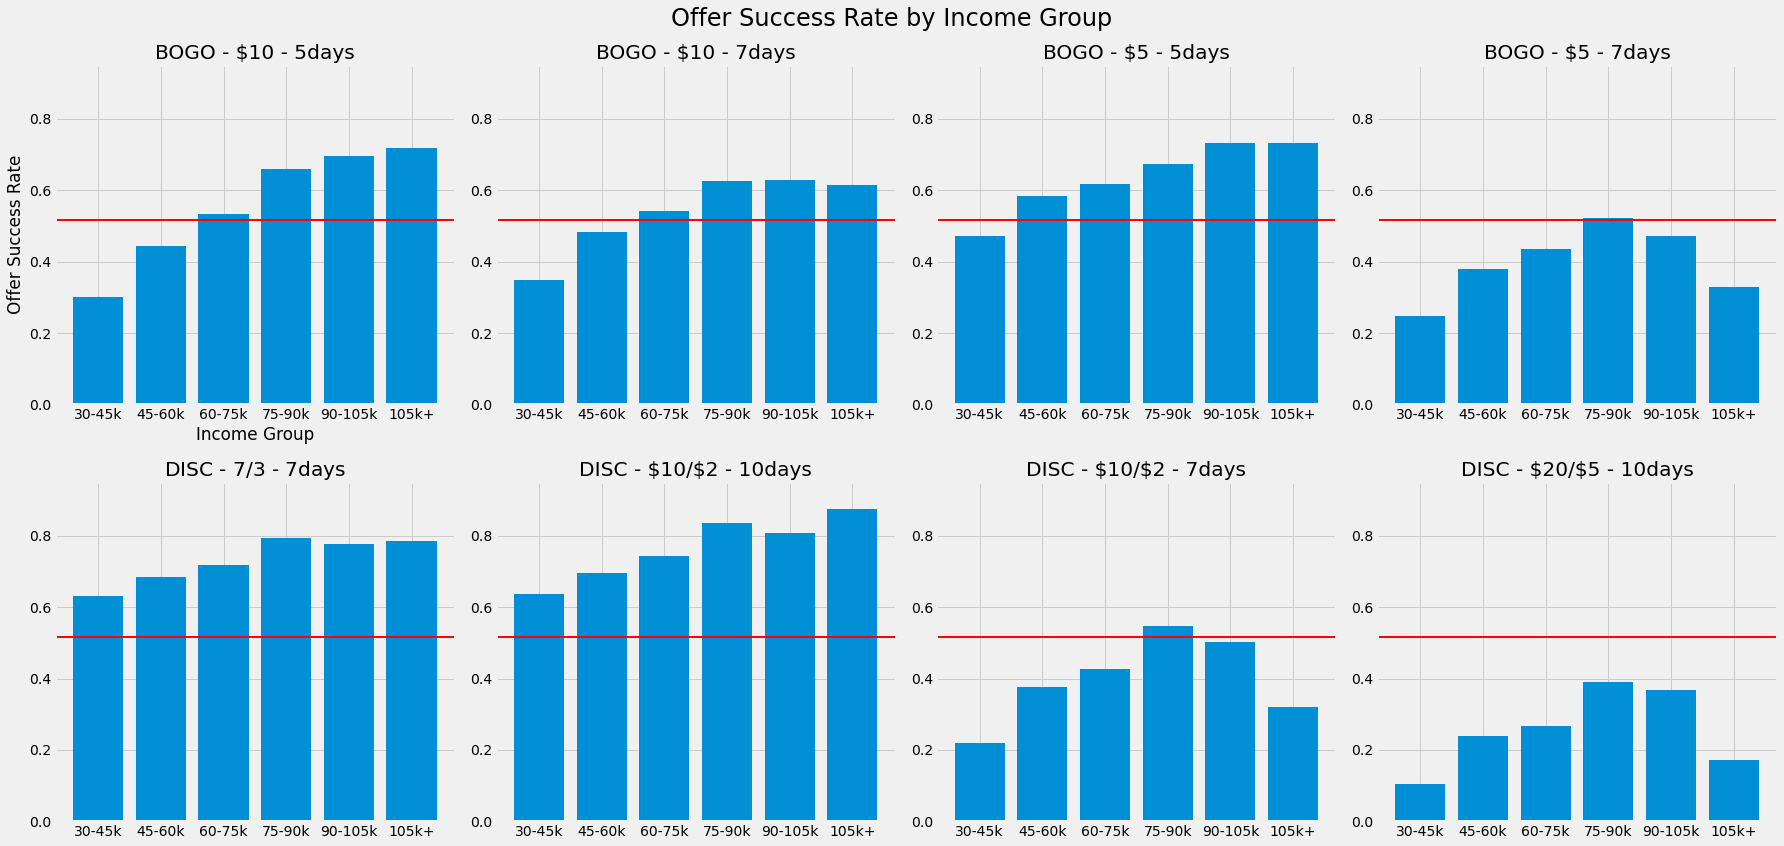

In [464]:
success_rate_by_income = bogo_disc_offers.groupby(['readable_id', 'income_group'])['offer_successful'].mean().reset_index()
avg_success_rate = bogo_disc_offers['offer_successful'].mean()
mapping = {'105k+':5, '90-105k':4, '60-75k':2, '45-60k':1, '30-45k':0, '75-90k':3,}

fig = plt.figure(figsize=(25,12))

for i, offer in enumerate(np.sort(bogo_disc_offers['readable_id'].unique())):
    ax = fig.add_subplot(2, 4, i+1, sharey=ax)
    data = success_rate_by_income.loc[success_rate_by_income['readable_id'] == offer]
    key = data['income_group'].map(mapping)

    x = data['income_group'].iloc[key.argsort()]
    y = data['offer_successful'].iloc[key.argsort()]
    
    ax.bar(x, y)
    
    if i == 0:
        ax.set_xlabel('Income Group')
        ax.set_ylabel('Offer Success Rate')
    
    ax.set_title(data['readable_id'].iloc[0])
    ax.axhline(avg_success_rate, color='red', linewidth=2)

fig.suptitle('Offer Success Rate by Income Group', fontsize=24)
fig.tight_layout()

In 5 offers (BOGO \\$10 - 5 days, BOGO \\$10 - 7 days, BOGO \\$5 - 5days, discount \\$7/\\$3 - 7days and discount \\$10/\\$2 - 10days), customers with higher income had higher rates of successful offers. In BOGO \\$5 - 7days, DISCOUNT \\$10/\\$2 - 7 days and DISCOUNT \\$20/\\$5 - 10 days, rates of successful completions rise until 75-90k, and then starts to decrease. 

In [366]:
bogo_disc_offers.groupby(['readable_id', 'income_group', 'age_group'])['offer_completed'].mean().reset_index().sort_values('offer_completed', ascending=False)

,readable_id,income_group,age_group,offer_completed
62,BOGO - $10 - 7days,75-90k,18-24,1.000000
210,DISC - \$10/\$2 - 10days,75-90k,18-24,1.000000
284,DISC - \$20/\$5 - 10days,75-90k,18-24,1.000000
137,BOGO - $5 - 7days,75-90k,25-34,1.000000
173,DISC - $7/$3 - 7days,75-90k,18-24,1.000000
...,...,...,...,...
8,BOGO - $10 - 5days,30-45k,55-64,0.266094
4,BOGO - $10 - 5days,30-45k,18-24,0.250000
26,BOGO - $10 - 5days,75-90k,25-34,0.200000
25,BOGO - $10 - 5days,75-90k,18-24,0.000000


In [367]:
bogo_disc_offers.groupby(['readable_id', 'income_group', 'gender'])['offer_completed'].mean().reset_index().sort_values('offer_completed', ascending=False)

,readable_id,income_group,gender,offer_completed
85,DISC - \$10/\$2 - 10days,105k+,F,0.910931
67,BOGO - $5 - 7days,90-105k,O,0.900000
86,DISC - \$10/\$2 - 10days,105k+,M,0.893805
50,BOGO - $5 - 5days,90-105k,O,0.888889
99,DISC - \$10/\$2 - 10days,90-105k,F,0.859649
...,...,...,...,...
6,BOGO - $10 - 5days,45-60k,M,0.376798
105,DISC - \$10/\$2 - 7days,30-45k,M,0.363434
122,DISC - \$20/\$5 - 10days,30-45k,M,0.314995
20,BOGO - $10 - 7days,30-45k,M,0.304706


In [368]:
bogo_disc_offers.groupby(['readable_id', 'age_group', 'gender'])['offer_completed'].mean().reset_index().sort_values('offer_completed', ascending=False)

,readable_id,age_group,gender,offer_completed
2,BOGO - $10 - 5days,18-24,O,1.000000
110,DISC - \$10/\$2 - 10days,25-34,O,1.000000
95,DISC - $7/$3 - 7days,45-54,O,0.928571
62,BOGO - $5 - 5days,75+,O,0.875000
123,DISC - \$10/\$2 - 10days,75+,F,0.853165
...,...,...,...,...
149,DISC - \$20/\$5 - 10days,18-24,O,0.333333
65,BOGO - $5 - 7days,18-24,O,0.333333
1,BOGO - $10 - 5days,18-24,M,0.277027
4,BOGO - $10 - 5days,25-34,M,0.276256


In [395]:
bogo_disc_offers.loc[bogo_disc_offers['gender']!='O'].groupby(['readable_id', 'income_group', 'age_group', 'gender'])['offer_completed'].mean().reset_index().sort_values('offer_completed', ascending=False).head(30)

,readable_id,income_group,age_group,gender,offer_completed
124,BOGO - $10 - 7days,75-90k,25-34,F,1.000000
196,BOGO - $5 - 5days,75-90k,18-24,F,1.000000
563,DISC - \$20/\$5 - 10days,75-90k,25-34,F,1.000000
562,DISC - \$20/\$5 - 10days,75-90k,18-24,F,1.000000
271,BOGO - $5 - 7days,75-90k,25-34,F,1.000000
342,DISC - $7/$3 - 7days,75-90k,18-24,F,1.000000
343,DISC - $7/$3 - 7days,75-90k,18-24,M,1.000000
344,DISC - $7/$3 - 7days,75-90k,25-34,F,1.000000
345,DISC - $7/$3 - 7days,75-90k,25-34,M,1.000000
123,BOGO - $10 - 7days,75-90k,18-24,M,1.000000


#### 2. Under which offer type (BOGO, DISCOUNT, INFORMATIONAL) do customers spend the most?


In [273]:
master_df.loc[master_df['bogo'] == 1, 'transactions_under_offer'].mean()

nan

#### 3. Does sending users more offers make them more likely to complete them?


In [ ]:
Create a machine learning model that will predict how much a user with certain demographics will spend after receiving a given offer_type.

<AxesSubplot:xlabel='readable_id'>

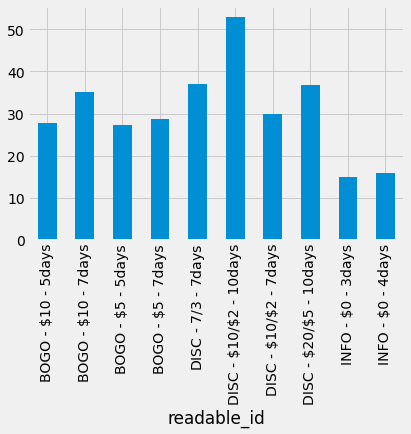

In [205]:
final_master_df.groupby(['readable_id'])['amt_spent_under_offer'].mean().plot.bar()

In [ ]:
final_master_df.grou

In [473]:
plt.style.use('fivethirtyeight')

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Num Customers')

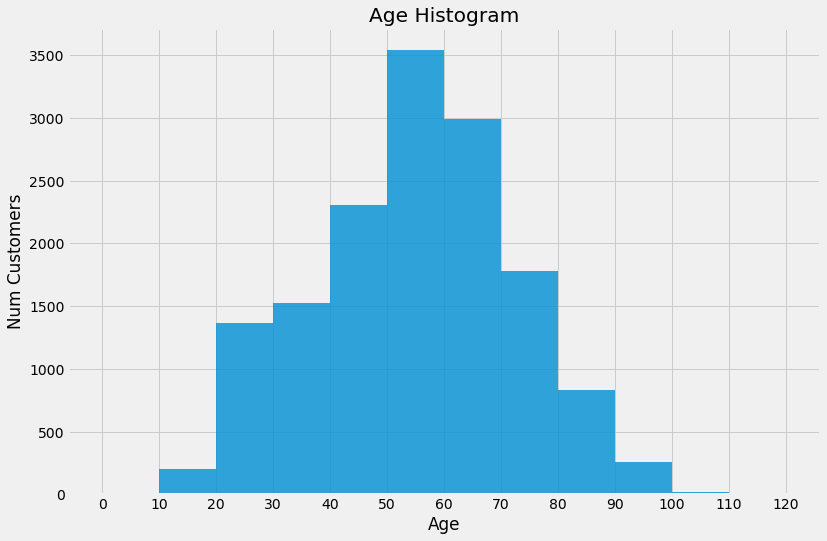

In [481]:
fig, ax = plt.subplots(figsize=(12,8));
x = profile['age'];
ax.hist(x, bins=12, range=(0,120), align='mid', alpha=0.8);
ax.set_xticks(range(0,121,10))
ax.set_title('Age Histogram')
ax.set_xlabel('Age')
ax.set_ylabel('Num Customers')

In [475]:
[str(x)[:-5] + 'k' for x in np.linspace(30000, 120000, 10)]



['30k', '40k', '50k', '60k', '70k', '80k', '90k', '100k', '110k', '120k']

Text(0, 0.5, 'Num Customers')

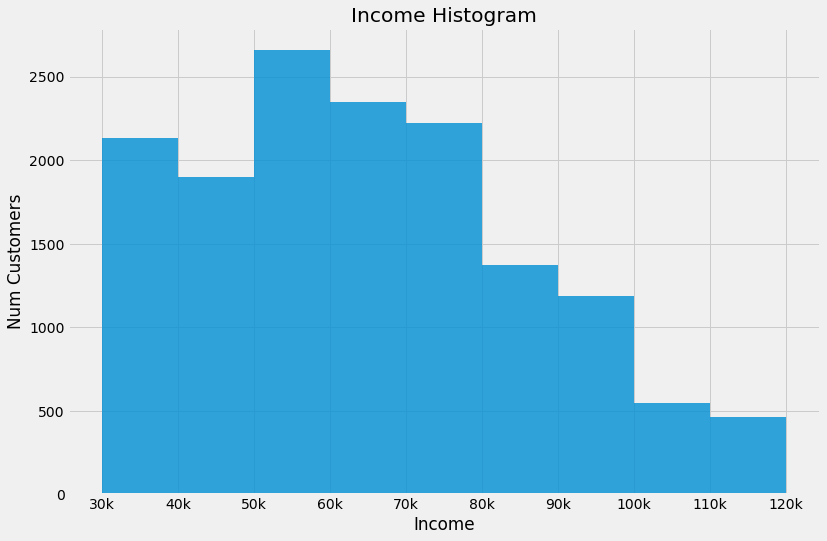

In [482]:
fig, ax = plt.subplots(figsize=(12,8));
x = profile['income'];
ax.hist(x, bins=9, range=(30000,120001), align='mid', alpha=0.8);
ax.set_xticks(np.linspace(30000, 120000, 10))
ax.set_xticklabels([str(x)[:-5] + 'k' for x in np.linspace(30000, 120000, 10)])
ax.set_title('Income Histogram')
ax.set_xlabel('Income')
ax.set_ylabel('Num Customers')


[Text(0, 0.0, '0%'),
 Text(0, 0.09999999999999999, '10%'),
 Text(0, 0.19999999999999998, '20%'),
 Text(0, 0.3, '30%'),
 Text(0, 0.39999999999999997, '40%'),
 Text(0, 0.49999999999999994, '50%'),
 Text(0, 0.6, '60%')]

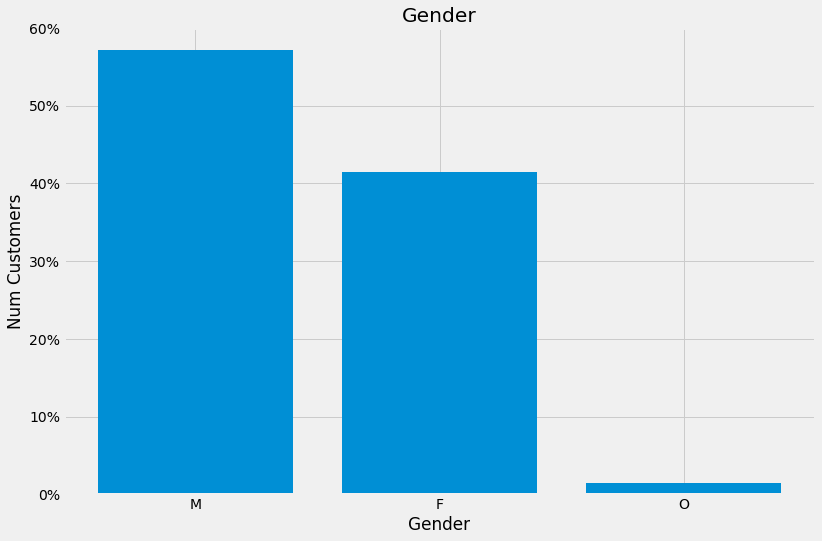

In [477]:
fig, ax = plt.subplots(figsize=(12,8))

data = df['gender'].value_counts(normalize=True).reset_index()
x = data['index'].tolist()
height = data['gender']

ax.bar(x=data['index'].tolist(), height=data['gender'].tolist())
ax.set_title('Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Num Customers')
ax.set_yticks(np.linspace(0,0.6,7))
ax.set_yticklabels("{:.0f}%".format(x) for x in np.linspace(0, 60, 7))

In [478]:
med_age = df['age'].median()
mean_age = df['age'].mean()

med_income = df['income'].median()
mean_income = df['income'].mean()

print("The median age is {}. The mean age is {:.1f}.".format(med_age, mean_age))
print("The median income is {}. The mean income is {:.1f}.".format(med_income, mean_income))

The median age is 55.0. The mean age is 53.8.
The median income is 62000.0. The mean income is 64337.0.


In [479]:
df['gender'].value_counts(normalize=True)

M    0.570791
F    0.414651
O    0.014558
Name: gender, dtype: float64

### Takeaways
The most common age group for starbucks customers is 50-59. The least common is 10-19 and 90-99. 
It appears they used 118 to mean the customers age is unknown, as there are 33772 instances of that age.

The most common income group is 50k to 60k, and the least common is 100k and above. 

There are more male customers (57%) than female customers (41%).

In [69]:
df[df['transaction_amt'] > 1000]

NameError: name 'df' is not defined

NameError: name 'df' is not defined

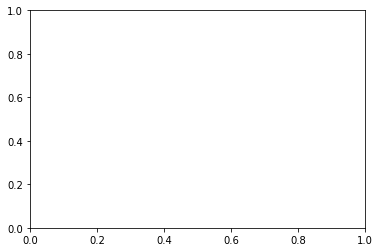

In [62]:
fig, ax = plt.subplots()

ax.hist(df['transaction_amt'], range=(0,50))
        

1. Frequency of transactions by gender, age, and income
2. Average Transaction amount by gender, age, and income
3. Total Spent in Experimeny by gender, age, and income

In [223]:
transactions = df.loc[df['event'] == 'transaction']
transactions.head()

,person,event,time,age,became_member_on,income,transaction_amt,offer_id,reward_received,channels,difficulty,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,20,2016-07-11,30000.0,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,42,2016-01-17,96000.0,34.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0
12659,54890f68699049c2a04d415abc25e717,transaction,0,36,2017-12-28,56000.0,13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,55,2017-10-16,94000.0,19.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,39,2017-12-17,67000.0,18.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0


<AxesSubplot:xlabel='age_group'>

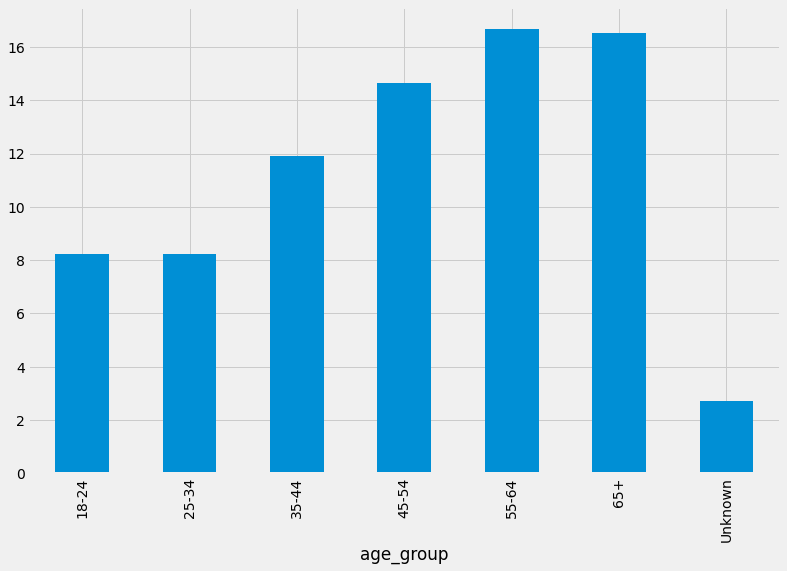

In [264]:
transactions.groupby(['age_group'])['transaction_amt'].mean().plot.bar(figsize=(12,8))

In [273]:
df.loc[df['person']== '1e9420836d554513ab90eba98552d0a9']

,person,event,time,age,became_member_on,income,transaction_amt,offer_id,reward_received,channels,difficulty,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
19,1e9420836d554513ab90eba98552d0a9,offer received,0,22,2017-09-25,70000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,"[email, mobile, social]",10.0,7.0,1.0,1.0,1.0,0.0,0,1,0,1,0,0
40779,1e9420836d554513ab90eba98552d0a9,offer viewed,96,22,2017-09-25,70000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,"[email, mobile, social]",10.0,7.0,1.0,1.0,1.0,0.0,0,1,0,1,0,0
53196,1e9420836d554513ab90eba98552d0a9,offer received,168,22,2017-09-25,70000.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,"[web, email, mobile, social]",10.0,5.0,1.0,1.0,1.0,1.0,0,1,0,1,0,0
69328,1e9420836d554513ab90eba98552d0a9,offer viewed,174,22,2017-09-25,70000.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,"[web, email, mobile, social]",10.0,5.0,1.0,1.0,1.0,1.0,0,1,0,1,0,0
79426,1e9420836d554513ab90eba98552d0a9,transaction,198,22,2017-09-25,70000.0,17.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230416,1e9420836d554513ab90eba98552d0a9,offer viewed,534,22,2017-09-25,70000.0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,"[web, email, mobile]",0.0,4.0,1.0,1.0,0.0,1.0,0,1,0,0,0,1
245143,1e9420836d554513ab90eba98552d0a9,offer received,576,22,2017-09-25,70000.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,"[web, email]",20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,0,1,0
257891,1e9420836d554513ab90eba98552d0a9,offer viewed,576,22,2017-09-25,70000.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,"[web, email]",20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,0,1,0
271788,1e9420836d554513ab90eba98552d0a9,transaction,600,22,2017-09-25,70000.0,28.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0


In [199]:
df.rename(columns={'reward_x':'reward_received', 'offer_type_y':'offer_type'}, inplace=True)


### Objectives
1. Predict how much a user will spend based on demographics and offer type.
2. Determine which demographics we should send which offers to. 
3. Which types of channels are are most effective and lead to customer purchases

In [202]:
df = pd.get_dummies(df, columns=['gender', 'offer_type'])


In [205]:
df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

determine if a transaction was made in the given duration


In [244]:
person_df = df.loc[df['person'] == '78afa995795e4d85b5d9ceeca43f5fef']
person_df.loc[(df['event'] == 'offer_viewed') | (df['event'] == 'offer_completed')]


,person,event,time,age,became_member_on,income,transaction_amt,offer_id,reward_received,channels,difficulty,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational


In [ ]:
def influenced_by_offer(person, df=df):
    for person in df['person'].unique():
        person_df = df.loc[df['person'] == person]
        
        
    
    